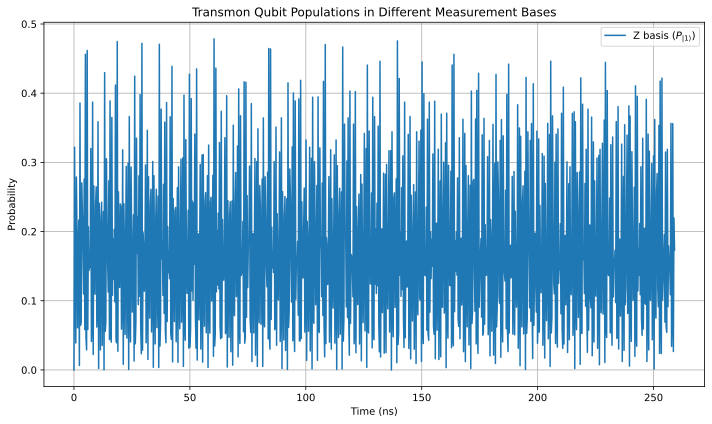

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

# Define the Transmon class as given by the user
class Transmon:
    def __init__(self, params):
        self.params = params.copy()
        
        # Set the energy eigenbasis truncation if not specified
        if "N_max" not in self.params:
            self.params["N_max"] = 2 * self.params["N_max_charge"] + 1
        else:
            assert self.params["N_max"] <= 2 * self.params["N_max_charge"] + 1
        
        self.build_ops()

    # Build Transmon Operators
    def build_ops(self):
        self.ops = {}
        self.ops["N"] = self.calc_n_op()
        self.ops["cos(φ)"] = self.build_cos_phi_op()
        self.ops["Id_charge"] = qt.qeye(2 * self.params["N_max_charge"] + 1)
        self.ops["Id"] = qt.qeye(self.params["N_max"])

    def calc_n_op(self):
        N_max_charge = self.params["N_max_charge"]
        return qt.Qobj(np.diag(np.arange(-N_max_charge, N_max_charge + 1)))

    def build_cos_phi_op(self):
        N_max_charge = self.params["N_max_charge"]
        return 0.5 * qt.Qobj(
            np.eye(2 * N_max_charge + 1, k=1) + np.eye(2 * N_max_charge + 1, k=-1)
        )

    # System Hamiltonian Definitions
    def get_H(self):
        Ej = self.params["Ej"]
        Ec = self.params["Ec"]
        ng = self.params["ng"]

        return (
            4 * Ec * (self.ops["N"] - ng * self.ops["Id_charge"]) ** 2
            - Ej * self.ops["cos(φ)"]
        )

    # System's eigenvalues and eigenvectors
    def get_eigensys(self):
        H = self.get_H()
        eigvals, eigvecs = H.eigenstates()
        return eigvals, eigvecs
    
    @property
    def H0(self):
        eigvals, _ = self.get_eigensys()
        eigvals = eigvals - eigvals[0]  # Rescale energies to set ground state energy to 0
        return qt.Qobj(np.diag(eigvals))

# Define parameters for the Transmon qubit
params = {
    "Ej": 16.0,        # Josephson energy (GHz)
    "Ec": 0.2,         # Charging energy (GHz)
    "ng": 0.0,         # Offset charge
    "N_max_charge": 10, # Maximum number of charge states
    "N_max": 21        # Total number of charge states (default, can be adjusted)
}

# Create Transmon object
transmon = Transmon(params)

# Get the Hamiltonian and eigenstates for the first 5 levels
eigvals, eigvecs = transmon.get_eigensys()
H0 = transmon.H0

# Extract the first 5 eigenstates and eigenvalues
eigvals_5 = eigvals[:5]
eigvecs_5 = eigvecs[:5]

# Define the Rabi frequency for the drive (realistic value)
Omega = 0.005 * (eigvals_5[1] - eigvals_5[0])  # Rabi frequency (GHz), 10% of the transition energy

# Define the time-dependent Rabi drive function
def drive_func(t, args):
    return np.cos(args['omega_d'] * t)

# Hamiltonian with the drive term
n_op = transmon.ops["N"]
H = [H0, [Omega * n_op, drive_func]]
args = {'omega_d': eigvals_5[1] - eigvals_5[0]}  # Drive frequency set to the qubit transition frequency

# Define the initial state (|1> state)
psi0 = eigvecs_5[0]  # Excited state |1>

# Time grid for evolution (20 Rabi periods)
tlist = np.linspace(0,   2 * np.pi / Omega, 1000)

# Solve the time evolution (using mesolve for a closed system)
result = qt.mesolve(H, psi0, tlist, c_ops=[], e_ops=[], args=args)

# Measure populations in X, Y, Z (rotating frame) bases
p_z, p_x, p_y = [], [], []
for t, psi in zip(tlist, result.states):
    # Project onto the |0> and |1> states for Z basis
    c0 = (eigvecs_5[0].dag() * psi)  # Extract the value from Qobj
    c1 = (eigvecs_5[1].dag() * psi)  # Extract the value from Qobj
    p_z.append(np.abs(c1)**2)

    # X and Y basis projections (for Bloch sphere)
    coh_rot = np.conj(c0) * c1 * np.exp(1j * (eigvals_5[1] - eigvals_5[0]) * t)
    sx = 2 * np.real(coh_rot)
    sy = -2 * np.imag(coh_rot)
    p_x.append((1 + sx) / 2)
    p_y.append((1 + sy) / 2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(tlist, p_z, label=r'Z basis ($P_{|1\rangle}$)')
# plt.plot(tlist, p_x, label=r'X basis ($P_{|+\rangle}$)')
# plt.plot(tlist, p_y, label=r'Y basis ($P_{|+y\rangle}$)')
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.title('Transmon Qubit Populations in Different Measurement Bases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
eigvals_5[1] - eigvals_5[0]

np.float64(4.850775470397084)

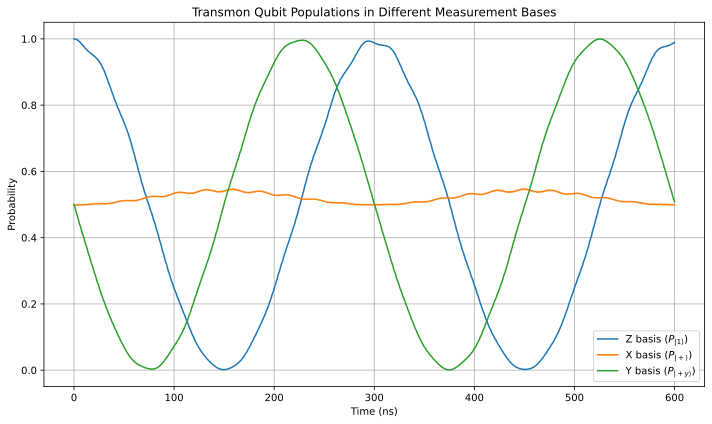

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

# Define the Transmon class as given by the user
class Transmon:
    def __init__(self, params):
        self.params = params.copy()
        
        # Set the energy eigenbasis truncation if not specified
        if "N_max" not in self.params:
            self.params["N_max"] = 2 * self.params["N_max_charge"] + 1
        else:
            assert self.params["N_max"] <= 2 * self.params["N_max_charge"] + 1
        
        self.build_ops()

    # Build Transmon Operators
    def build_ops(self):
        self.ops = {}
        self.ops["N"] = self.calc_n_op()
        self.ops["cos(φ)"] = self.build_cos_phi_op()
        self.ops["Id_charge"] = qt.qeye(2 * self.params["N_max_charge"] + 1)
        self.ops["Id"] = qt.qeye(self.params["N_max"])

    def calc_n_op(self):
        N_max_charge = self.params["N_max_charge"]
        return qt.Qobj(np.diag(np.arange(-N_max_charge, N_max_charge + 1)))

    def build_cos_phi_op(self):
        N_max_charge = self.params["N_max_charge"]
        return 0.5 * qt.Qobj(
            np.eye(2 * N_max_charge + 1, k=1) + np.eye(2 * N_max_charge + 1, k=-1)
        )

    # System Hamiltonian Definitions
    def get_H(self):
        Ej = self.params["Ej"]
        Ec = self.params["Ec"]
        ng = self.params["ng"]

        return (
            4 * Ec * (self.ops["N"] - ng * self.ops["Id_charge"]) ** 2
            - Ej * self.ops["cos(φ)"]
        )

    # System's eigenvalues and eigenvectors
    def get_eigensys(self):
        H = self.get_H()
        eigvals, eigvecs = H.eigenstates()
        return eigvals, eigvecs
    
    @property
    def H0(self):
        eigvals, _ = self.get_eigensys()
        eigvals = eigvals - eigvals[0]  # Rescale energies to set ground state energy to 0
        return qt.Qobj(np.diag(eigvals))

# Define parameters for the Transmon qubit
params = {
    "Ej": 12.0,        # Josephson energy (GHz)
    "Ec": 0.2,         # Charging energy (GHz)
    "ng": 0.0,         # Offset charge
    "N_max_charge": 10, # Maximum number of charge states
    "N_max": 21        # Total number of charge states (default, can be adjusted)
}

# Create Transmon object
transmon = Transmon(params)

# Get the Hamiltonian and eigenstates for the first 5 levels
eigvals, eigvecs = transmon.get_eigensys()
dim = transmon.params["N_max"]
H0 = transmon.H0

# Extract the first 5 eigenstates and eigenvalues
eigvals_5 = eigvals[:10]
eigvecs_5 = eigvecs[:10]

# Transform the n operator to the energy basis
n_op = transmon.ops["N"]
n_energy_arr = np.zeros((dim, dim), dtype=complex)
for i in range(dim):
    for j in range(dim):
        n_energy_arr[i, j] = (eigvecs[i].dag() * n_op * eigvecs[j])

n_energy = qt.Qobj(n_energy_arr)

# Analytically calculate the required Omega for 100 ns Rabi period
me = np.abs((eigvecs[0].dag() * n_op * eigvecs[1]))
period = 300.0  # Desired Rabi period (ns)
omega_r = 2 * np.pi / period
Omega = omega_r / me  # Rabi frequency (GHz)

# Define the time-dependent Rabi drive function
def drive_func(t, args):
    return np.cos(args['omega_d'] * t)




# Hamiltonian with the drive term
H = [H0, [Omega * n_energy, drive_func]]
args = {'omega_d': eigvals_5[1] - eigvals_5[0]}  # Drive frequency set to the qubit transition frequency

# Define the initial state (|1> state)
psi0 = qt.basis(dim, 1)  # In energy basis

# Time grid for evolution (20 Rabi periods)
tlist = np.linspace(0, 2* period, 1000)

# Solve the time evolution (using mesolve for a closed system)
result = qt.mesolve(H, psi0, tlist, c_ops=[], e_ops=[], args=args)

# Measure populations in X, Y, Z (rotating frame) bases
p_z, p_x, p_y = [], [], []
for t, psi in zip(tlist, result.states):
    # Project onto the |0> and |1> states for Z basis
    c0 = psi.full()[0, 0]  # Extract the value from Qobj
    c1 = psi.full()[1, 0]  # Extract the value from Qobj
    p_z.append(np.abs(c1)**2)

    # X and Y basis projections (for Bloch sphere)
    coh_rot = np.conj(c0) * c1 * np.exp(1j * (eigvals_5[1] - eigvals_5[0]) * t)
    sx = 2 * np.real(coh_rot)
    sy = -2 * np.imag(coh_rot)
    p_x.append((1 + sx) / 2)
    p_y.append((1 + sy) / 2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(tlist, p_z, label=r'Z basis ($P_{|1\rangle}$)')
plt.plot(tlist, p_x, label=r'X basis ($P_{|+\rangle}$)')
plt.plot(tlist, p_y, label=r'Y basis ($P_{|+y\rangle}$)')
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.title('Transmon Qubit Populations in Different Measurement Bases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

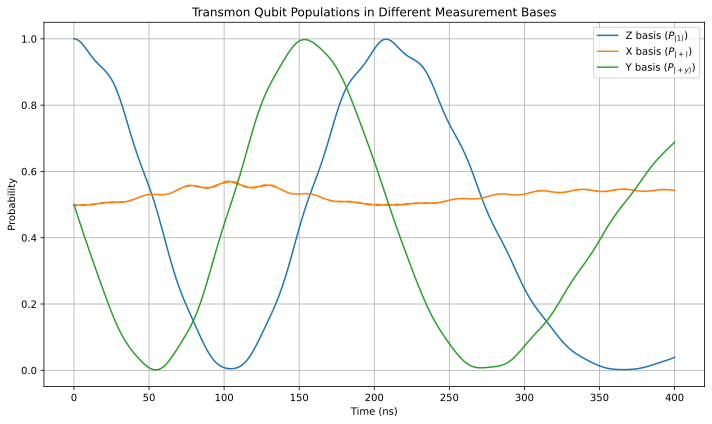

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

# Define the Transmon class as given by the user
class Transmon:
    def __init__(self, params):
        self.params = params.copy()
        
        # Set the energy eigenbasis truncation if not specified
        if "N_max" not in self.params:
            self.params["N_max"] = 2 * self.params["N_max_charge"] + 1
        else:
            assert self.params["N_max"] <= 2 * self.params["N_max_charge"] + 1
        
        self.build_ops()

    # Build Transmon Operators
    def build_ops(self):
        self.ops = {}
        self.ops["N"] = self.calc_n_op()
        self.ops["cos(φ)"] = self.build_cos_phi_op()
        self.ops["Id_charge"] = qt.qeye(2 * self.params["N_max_charge"] + 1)
        self.ops["Id"] = qt.qeye(self.params["N_max"])

    def calc_n_op(self):
        N_max_charge = self.params["N_max_charge"]
        return qt.Qobj(np.diag(np.arange(-N_max_charge, N_max_charge + 1)))

    def build_cos_phi_op(self):
        N_max_charge = self.params["N_max_charge"]
        return 0.5 * qt.Qobj(
            np.eye(2 * N_max_charge + 1, k=1) + np.eye(2 * N_max_charge + 1, k=-1)
        )

    # System Hamiltonian Definitions
    def get_H(self):
        Ej = self.params["Ej"]
        Ec = self.params["Ec"]
        ng = self.params["ng"]

        return (
            4 * Ec * (self.ops["N"] - ng * self.ops["Id_charge"]) ** 2
            - Ej * self.ops["cos(φ)"]
        )

    # System's eigenvalues and eigenvectors
    def get_eigensys(self):
        H = self.get_H()
        eigvals, eigvecs = H.eigenstates()
        return eigvals, eigvecs
    
    @property
    def H0(self):
        eigvals, _ = self.get_eigensys()
        eigvals = eigvals - eigvals[0]  # Rescale energies to set ground state energy to 0
        return qt.Qobj(np.diag(eigvals))

# Define parameters for the Transmon qubit
params = {
    "Ej": 12.0,        # Josephson energy (GHz)
    "Ec": 0.2,         # Charging energy (GHz)
    "ng": 0.0,         # Offset charge
    "N_max_charge": 10, # Maximum number of charge states
    "N_max": 21        # Total number of charge states (default, can be adjusted)
}

# Create Transmon object
transmon = Transmon(params)

# Get the Hamiltonian and eigenstates for the first 5 levels
eigvals, eigvecs = transmon.get_eigensys()
dim = transmon.params["N_max"]
H0 = transmon.H0

# Extract the first 5 eigenstates and eigenvalues
eigvals_5 = eigvals[:10]
eigvecs_5 = eigvecs[:10]

# Transform the n operator to the energy basis
n_op = transmon.ops["N"]
n_energy_arr = np.zeros((dim, dim), dtype=complex)
for i in range(dim):
    for j in range(dim):
        n_energy_arr[i, j] = (eigvecs[i].dag() * n_op * eigvecs[j])

n_energy = qt.Qobj(n_energy_arr)

# Compute matrix element
me = np.abs((eigvecs[0].dag() * n_op * eigvecs[1]))

# Gaussian pulse parameters (wide Gaussian to approximate continuous drive over the time window)
period = 200.0  # Reference Rabi period (ns) for peak strength
omega_r = 2 * np.pi / period
Omega = omega_r / me  # Peak Rabi frequency (GHz)
sigma = 200.0  # Gaussian width (ns) - large to cover the time with nearly constant drive
t0 = 100.0  # Center the pulse at the midpoint of tlist

# Envelope function
def envelope(t, args):
    # return 1
    return Omega * np.exp(- (t - t0)**2 / (2 * sigma**2))

# Drive function (Gaussian-enveloped cosine)
def drive_func(t, args):
    return envelope(t, args) * np.cos(args['omega_d'] * t)

# Hamiltonian with the drive term
H = [H0, [n_energy, drive_func]]
args = {'omega_d': eigvals_5[1] - eigvals_5[0]}  # Drive frequency set to the qubit transition frequency

# Define the initial state (|1> state)
psi0 = qt.basis(dim, 1)  # In energy basis

# Time grid for evolution (matches original: 2 Rabi periods)
tlist = np.linspace(0, 2 * period, 1000)

# Solve the time evolution (using mesolve for a closed system)
result = qt.mesolve(H, psi0, tlist, c_ops=[], e_ops=[], args=args)

# Measure populations in X, Y, Z (rotating frame) bases
p_z, p_x, p_y = [], [], []
for t, psi in zip(tlist, result.states):
    # Project onto the |0> and |1> states for Z basis
    c0 = psi.full()[0, 0]  # Extract the value from Qobj
    c1 = psi.full()[1, 0]  # Extract the value from Qobj
    p_z.append(np.abs(c1)**2)

    # X and Y basis projections (for Bloch sphere)
    coh_rot = np.conj(c0) * c1 * np.exp(1j * (eigvals_5[1] - eigvals_5[0]) * t)
    sx = 2 * np.real(coh_rot)
    sy = -2 * np.imag(coh_rot)
    p_x.append((1 + sx) / 2)
    p_y.append((1 + sy) / 2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(tlist, p_z, label=r'Z basis ($P_{|1\rangle}$)')
plt.plot(tlist, p_x, label=r'X basis ($P_{|+\rangle}$)')
plt.plot(tlist, p_y, label=r'Y basis ($P_{|+y\rangle}$)')
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.title('Transmon Qubit Populations in Different Measurement Bases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

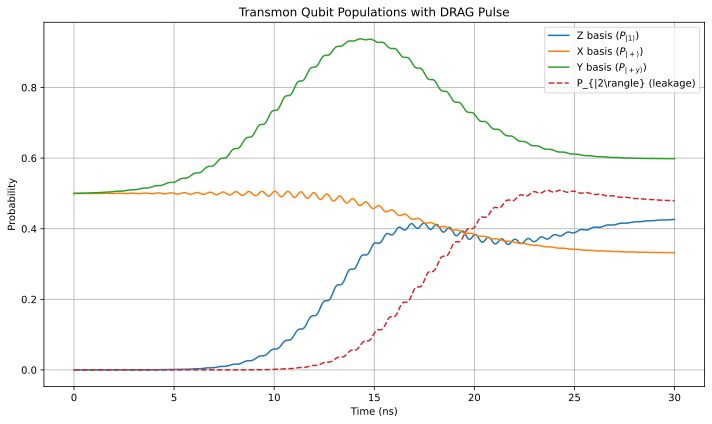

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

# Define the Transmon class as given by the user
class Transmon:
    def __init__(self, params):
        self.params = params.copy()
        
        # Set the energy eigenbasis truncation if not specified
        if "N_max" not in self.params:
            self.params["N_max"] = 2 * self.params["N_max_charge"] + 1
        else:
            assert self.params["N_max"] <= 2 * self.params["N_max_charge"] + 1
        
        self.build_ops()

    # Build Transmon Operators
    def build_ops(self):
        self.ops = {}
        self.ops["N"] = self.calc_n_op()
        self.ops["cos(φ)"] = self.build_cos_phi_op()
        self.ops["Id_charge"] = qt.qeye(2 * self.params["N_max_charge"] + 1)
        self.ops["Id"] = qt.qeye(self.params["N_max"])

    def calc_n_op(self):
        N_max_charge = self.params["N_max_charge"]
        return qt.Qobj(np.diag(np.arange(-N_max_charge, N_max_charge + 1)))

    def build_cos_phi_op(self):
        N_max_charge = self.params["N_max_charge"]
        return 0.5 * qt.Qobj(
            np.eye(2 * N_max_charge + 1, k=1) + np.eye(2 * N_max_charge + 1, k=-1)
        )

    # System Hamiltonian Definitions
    def get_H(self):
        Ej = self.params["Ej"]
        Ec = self.params["Ec"]
        ng = self.params["ng"]

        return (
            4 * Ec * (self.ops["N"] - ng * self.ops["Id_charge"]) ** 2
            - Ej * self.ops["cos(φ)"]
        )

    # System's eigenvalues and eigenvectors
    def get_eigensys(self):
        H = self.get_H()
        eigvals, eigvecs = H.eigenstates()
        return eigvals, eigvecs
    
    @property
    def H0(self):
        eigvals, _ = self.get_eigensys()
        eigvals = eigvals - eigvals[0]  # Rescale energies to set ground state energy to 0
        return qt.Qobj(np.diag(eigvals))

# Define parameters for the Transmon qubit
params = {
    "Ej": 16.0,        # Josephson energy (GHz)
    "Ec": 0.2,         # Charging energy (GHz)
    "ng": 0.0,         # Offset charge
    "N_max_charge": 10, # Maximum number of charge states
    "N_max": 21        # Total number of charge states (default, can be adjusted)
}

# Create Transmon object
transmon = Transmon(params)

# Get the Hamiltonian and eigenstates for the first 5 levels
eigvals, eigvecs = transmon.get_eigensys()
dim = transmon.params["N_max"]
H0 = transmon.H0

# Extract the first 5 eigenstates and eigenvalues
eigvals_5 = eigvals[:5]
eigvecs_5 = eigvecs[:5]

# Transform the n operator to the energy basis
n_op = transmon.ops["N"]
n_energy_arr = np.zeros((dim, dim), dtype=complex)
for i in range(dim):
    for j in range(dim):
        n_energy_arr[i, j] = (eigvecs[i].dag() * n_op * eigvecs[j])

n_energy = qt.Qobj(n_energy_arr)

# Compute matrix element and anharmonicity
me = np.abs((eigvecs[0].dag() * n_op * eigvecs[1]))
eta = eigvals_5[2] - eigvals_5[1] - (eigvals_5[1] - eigvals_5[0])  # ≈ -0.2 GHz
beta = 0#-1.0 / eta  # DRAG coefficient

# Gaussian pulse parameters for π rotation (gate time ~20 ns)
sigma = 5.0  # Gaussian width (ns)
t0 = 3 * sigma  # Center the pulse
amp = np.pi / (me * np.sqrt(2 * np.pi) * sigma)  # Amplitude for π area

# Envelope functions
def envelope(t, args):
    return amp * np.exp(- (t - t0)**2 / (2 * sigma**2))

def dot_envelope(t, args):
    return amp * (- (t - t0) / sigma**2) * np.exp(- (t - t0)**2 / (2 * sigma**2))

# Drive functions (in-phase and quadrature)
def drive_i(t, args):
    return envelope(t, args) * np.cos(args['omega_d'] * t)

def drive_q(t, args):
    return beta * dot_envelope(t, args) * np.sin(args['omega_d'] * t)  # DRAG term

# Toggle DRAG
use_drag = True  # Set to False to disable DRAG

# Hamiltonian with drive term(s)
H = [H0, [n_energy, drive_i]]
if use_drag:
    H.append([n_energy, drive_q])

args = {'omega_d': eigvals_5[1] - eigvals_5[0]}  # Drive frequency

# Define the initial state (|0> to demonstrate π flip)
psi0 = qt.basis(dim, 0)

# Time grid for evolution (covers pulse duration)
tlist = np.linspace(0, 6 * sigma, 1000)

# Solve the time evolution
result = qt.mesolve(H, psi0, tlist, c_ops=[], e_ops=[], args=args)

# Measure populations
p_z, p_x, p_y, p_2 = [], [], [], []
for t, psi in zip(tlist, result.states):
    c0 = psi.full()[0, 0]
    c1 = psi.full()[1, 0]
    c2 = psi.full()[2, 0]
    p_z.append(np.abs(c1)**2)
    p_2.append(np.abs(c2)**2)

    coh_rot = np.conj(c0) * c1 * np.exp(1j * (eigvals_5[1] - eigvals_5[0]) * t)
    sx = 2 * np.real(coh_rot)
    sy = -2 * np.imag(coh_rot)
    p_x.append((1 + sx) / 2)
    p_y.append((1 + sy) / 2)

# Plot the results (add P_|2> for leakage)
plt.figure(figsize=(10, 6))
plt.plot(tlist, p_z, label=r'Z basis ($P_{|1\rangle}$)')
plt.plot(tlist, p_x, label=r'X basis ($P_{|+\rangle}$)')
plt.plot(tlist, p_y, label=r'Y basis ($P_{|+y\rangle}$)')
plt.plot(tlist, p_2, label=r'P_{|2\rangle} (leakage)', linestyle='--')
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.title('Transmon Qubit Populations with DRAG Pulse')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

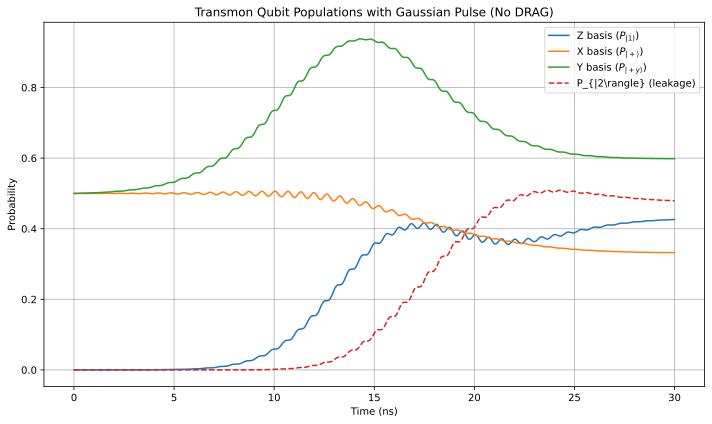

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

# Define the Transmon class as given by the user
class Transmon:
    def __init__(self, params):
        self.params = params.copy()
        
        # Set the energy eigenbasis truncation if not specified
        if "N_max" not in self.params:
            self.params["N_max"] = 2 * self.params["N_max_charge"] + 1
        else:
            assert self.params["N_max"] <= 2 * self.params["N_max_charge"] + 1
        
        self.build_ops()

    # Build Transmon Operators
    def build_ops(self):
        self.ops = {}
        self.ops["N"] = self.calc_n_op()
        self.ops["cos(φ)"] = self.build_cos_phi_op()
        self.ops["Id_charge"] = qt.qeye(2 * self.params["N_max_charge"] + 1)
        self.ops["Id"] = qt.qeye(self.params["N_max"])

    def calc_n_op(self):
        N_max_charge = self.params["N_max_charge"]
        return qt.Qobj(np.diag(np.arange(-N_max_charge, N_max_charge + 1)))

    def build_cos_phi_op(self):
        N_max_charge = self.params["N_max_charge"]
        return 0.5 * qt.Qobj(
            np.eye(2 * N_max_charge + 1, k=1) + np.eye(2 * N_max_charge + 1, k=-1)
        )

    # System Hamiltonian Definitions
    def get_H(self):
        Ej = self.params["Ej"]
        Ec = self.params["Ec"]
        ng = self.params["ng"]

        return (
            4 * Ec * (self.ops["N"] - ng * self.ops["Id_charge"]) ** 2
            - Ej * self.ops["cos(φ)"]
        )

    # System's eigenvalues and eigenvectors
    def get_eigensys(self):
        H = self.get_H()
        eigvals, eigvecs = H.eigenstates()
        return eigvals, eigvecs
    
    @property
    def H0(self):
        eigvals, _ = self.get_eigensys()
        eigvals = eigvals - eigvals[0]  # Rescale energies to set ground state energy to 0
        return qt.Qobj(np.diag(eigvals))

# Define parameters for the Transmon qubit
params = {
    "Ej": 16.0,        # Josephson energy (GHz)
    "Ec": 0.2,         # Charging energy (GHz)
    "ng": 0.0,         # Offset charge
    "N_max_charge": 10, # Maximum number of charge states
    "N_max": 21        # Total number of charge states (default, can be adjusted)
}

# Create Transmon object
transmon = Transmon(params)

# Get the Hamiltonian and eigenstates for the first 5 levels
eigvals, eigvecs = transmon.get_eigensys()
dim = transmon.params["N_max"]
H0 = transmon.H0

# Extract the first 5 eigenstates and eigenvalues
eigvals_5 = eigvals[:5]
eigvecs_5 = eigvecs[:5]

# Transform the n operator to the energy basis
n_op = transmon.ops["N"]
n_energy_arr = np.zeros((dim, dim), dtype=complex)
for i in range(dim):
    for j in range(dim):
        n_energy_arr[i, j] = (eigvecs[i].dag() * n_op * eigvecs[j])

n_energy = qt.Qobj(n_energy_arr)

# Compute matrix element and anharmonicity
me = np.abs((eigvecs[0].dag() * n_op * eigvecs[1]))
eta = eigvals_5[2] - eigvals_5[1] - (eigvals_5[1] - eigvals_5[0])  # ≈ -0.2 GHz

# Gaussian pulse parameters for π rotation (gate time ~20 ns)
sigma = 5.0  # Gaussian width (ns)
t0 = 3 * sigma  # Center the pulse
amp = np.pi / (me * np.sqrt(2 * np.pi) * sigma)  # Amplitude for π area

# Envelope functions
def envelope(t, args):
    return amp * np.exp(- (t - t0)**2 / (2 * sigma**2))

# Drive functions (only in-phase for pure Gaussian)
def drive_i(t, args):
    return envelope(t, args) * np.cos(args['omega_d'] * t)

# Hamiltonian with drive term (no DRAG)
H = [H0, [n_energy, drive_i]]

args = {'omega_d': eigvals_5[1] - eigvals_5[0]}  # Drive frequency

# Define the initial state (|0> to demonstrate π flip)
psi0 = qt.basis(dim, 0)

# Time grid for evolution (covers pulse duration)
tlist = np.linspace(0, 6 * sigma, 1000)

# Solve the time evolution
result = qt.mesolve(H, psi0, tlist, c_ops=[], e_ops=[], args=args)

# Measure populations
p_z, p_x, p_y, p_2 = [], [], [], []
for t, psi in zip(tlist, result.states):
    c0 = psi.full()[0, 0]
    c1 = psi.full()[1, 0]
    c2 = psi.full()[2, 0]
    p_z.append(np.abs(c1)**2)
    p_2.append(np.abs(c2)**2)

    coh_rot = np.conj(c0) * c1 * np.exp(1j * (eigvals_5[1] - eigvals_5[0]) * t)
    sx = 2 * np.real(coh_rot)
    sy = -2 * np.imag(coh_rot)
    p_x.append((1 + sx) / 2)
    p_y.append((1 + sy) / 2)

# Plot the results (add P_|2> for leakage)
plt.figure(figsize=(10, 6))
plt.plot(tlist, p_z, label=r'Z basis ($P_{|1\rangle}$)')
plt.plot(tlist, p_x, label=r'X basis ($P_{|+\rangle}$)')
plt.plot(tlist, p_y, label=r'Y basis ($P_{|+y\rangle}$)')
plt.plot(tlist, p_2, label=r'P_{|2\rangle} (leakage)', linestyle='--')
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.title('Transmon Qubit Populations with Gaussian Pulse (No DRAG)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()